# FlowMixer: Implementation Notebook - TENSORFLOW
# Chaotic Attractors Prediction: Lorenz, Rossler and Aizawa
## Comparison with NBEATS and RC (Reservoir Computing)
### A Neural Architecture for Cross-Domain Time Series Forecasting and Dynamical Systems Prediction

This notebook provides the implementation of "FlowMixer Neural Architecture for Versatile Long Horizon Time Series Forecasting and Dynamical Systems Predictions").

## Overview

FlowMixer is a versatile enural architecture for time series forecasting and dynamical system prediction. This notebook demonstrates the practical implementation of:

1. **Core Architecture Components**:
   - SOBR: Semi Orthogonal Basic Reservoir, implemented within FlowMixer
   - Reversible Instance Normalization (RevIN)
   - Non-negative matrix mixing layers
   - Adaptive skip connections
   - Time and feature mixing modules

2. **Key Applications**:

   - Chaotic system prediction


## Implementation Structure

The notebook is organized into several key sections:

1. **Data Processing**:
   - Custom data loader for time series
   - Spatial vectorization/devectorization utilities
   - Up/downsampling functions for flow data

2. **Model Architecture**:
   - RevNorm layer implementation
   - Noise injection module
   - MixingModule for time-feature interactions
   - Complete FlowMixer model with SOBR

3. **Training and Evaluation**:
   - Model configuration and training setup
   - Visualization utilities
   - Performance evaluation metrics

## Requirements

- TensorFlow 2.x
- CuPy (for GPU acceleration)
- NumPy
- Matplotlib
- Pandas


## Notes

- The implementation focuses on reproducibility and clarity
- GPU acceleration is utilized where possible for computational efficiency
- Hyperparameters can be adjusted based on specific use cases
- The code is structured to facilitate experimentation with different configurations



In [ ]:
# @title Initialization
import os
import io
import locale
locale.getpreferredencoding = lambda: "UTF-8" # Just in Case

import numpy as np
import cupy as cp
import tensorflow as tf
import networkx as nx

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Layer, Input, Lambda
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import AdamW, SGD
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Model


# Set random seed for reproducibility
np.random.seed(888)
cp.random.seed(888)
tf.random.set_seed(888)




In [ ]:
# @title I. DataGen

# RK4 solver for various chaotic trajectories

# Parameters
dt = 0.01  # 0.01 0.025
T = 125.0  # seconds 250 gives good rresults
t = cp.arange(0, T + dt, dt)
ns = 1  # Number of trajectories
nt = len(t)
normalize = False
batch_size = 32
nb_features = 6 # Normal 3, 6 adding negative copies
init_xyz = np.array([1.0, 1.0, 1.0]) # Initial datapoint
burn_in = 200 # initail datapoints to discard

# Lorenz system parameters
sigma, beta, rho = 10.0, 8/3, 28.0
# Rössler system parameters
ar, br, cr = 0.2, 0.2, 5.7
# Chen system parameters
ac, bc, cc = 35, 3, 28
# Aizawa system parameters
az, bz, cz, dz, ez, fz = 0.95, 0.7, 0.6, 3.5, 0.25, 0.1


# Lorenz
@cp.fuse()
def lorenz_deriv(x, y, z, sigma=sigma, beta=beta, rho=rho):
    dx = sigma * (y - x)
    dy = x * (rho - z) - y
    dz = x * y - beta * z
    return dx, dy, dz

# Rossler
@cp.fuse()
def rossler_deriv(x, y, z, a=ar, b=br, c=cr):
    dx = -y - z
    dy = x + a * y
    dz = b + z * (x - c)
    return dx, dy, dz

# Chen
@cp.fuse()
def chen_deriv(x, y, z, a=ac, b=bc, c=cc):
    dx = a * (y - x)
    dy = (c - a) * x - x * z + c * y
    dz = x * y - b * z
    return dx, dy, dz

# Aizawa
@cp.fuse()
def aizawa_deriv(x, y, z, a=az, b=bz, c=cz, d=dz, e=ez, f=fz):
    dx = (z - b) * x - d * y
    dy = d * x + (z - b) * y
    dz = c + a * z - z**3 / 3 - (x**2 + y**2) * (1 + e * z) + f * z * x**3
    return dx, dy, dz


# Main data generation function
def generate_trajectories_gpu(deriv_func, ns=ns, nt=nt, dt=dt, initial_conditions=None, nb_features=3, dtype_=cp.float32):
    trajectories = cp.zeros((ns, nt, nb_features), dtype=dtype_)

    if initial_conditions is None:
        trajectories[:, 0, :3] = cp.random.rand(ns, 3).astype(dtype_)
    else:
        trajectories[:, 0, :3] = cp.asarray(initial_conditions).astype(dtype_)

    for i in tqdm(range(1, nt), desc="Generating trajectories"):
        x, y, z = trajectories[:, i-1, 0], trajectories[:, i-1, 1], trajectories[:, i-1, 2]
        #vx, vy, vz = trajectories[:, i-1, 3], trajectories[:, i-1, 4], trajectories[:, i-1, 5]

        k1x, k1y, k1z = deriv_func(x, y, z)
        k2x, k2y, k2z = deriv_func(x + dt*k1x/2, y + dt*k1y/2, z + dt*k1z/2)
        k3x, k3y, k3z = deriv_func(x + dt*k2x/2, y + dt*k2y/2, z + dt*k2z/2)
        k4x, k4y, k4z = deriv_func(x + dt*k3x, y + dt*k3y, z + dt*k3z)

        dx = (dt/6) * (k1x + 2*k2x + 2*k3x + k4x)
        dy = (dt/6) * (k1y + 2*k2y + 2*k3y + k4y)
        dz = (dt/6) * (k1z + 2*k2z + 2*k3z + k4z)

        trajectories[:, i, 0] = x + dx
        trajectories[:, i, 1] = y + dy
        trajectories[:, i, 2] = z + dz

        trajectories[:, i, 3] = -(x + dx) #(x + dx)*(y + dy)
        trajectories[:, i, 4] = -(y + dy) #(x + dx)*(z + dz)
        trajectories[:, i, 5] = -(z + dz)


        #trajectories[:, i, 3] = dx/dt
        #trajectories[:, i, 4] = dy/dt
        #trajectories[:, i, 5] = dz/dt

    return trajectories.get()



# Generate trajectories

print("Generating Lorenz attractor data...")
data_lorenz = generate_trajectories_gpu(lorenz_deriv, ns=ns, nt=nt, dt=dt, initial_conditions=init_xyz, nb_features=nb_features)
print("Generating Rossler attractor data...")
data_rossler = generate_trajectories_gpu(rossler_deriv, ns=ns, nt=nt, dt=dt, initial_conditions=init_xyz, nb_features=nb_features)
print("Generating Chen attractor data...")
data_chen = generate_trajectories_gpu(chen_deriv, ns=ns, nt=nt, dt=dt, initial_conditions=init_xyz, nb_features=nb_features)
print("Generating Aizawa attractor data...")
data_aizawa = generate_trajectories_gpu(aizawa_deriv, ns=ns, nt=nt, dt=dt, initial_conditions=init_xyz, nb_features=nb_features)


data_lorenz = data_lorenz[:, burn_in:, :]
data_rossler = data_rossler[:, burn_in:, :]
data_chen = data_chen[:, burn_in:, :]
data_aizawa = data_aizawa[:, burn_in:, :]



Generating Lorenz attractor data...


Generating trajectories: 100%|██████████| 12500/12500 [00:14<00:00, 836.02it/s]


Generating Rossler attractor data...


Generating trajectories: 100%|██████████| 12500/12500 [00:14<00:00, 865.20it/s]


Generating Chen attractor data...


Generating trajectories: 100%|██████████| 12500/12500 [00:14<00:00, 854.83it/s]


Generating Aizawa attractor data...


Generating trajectories: 100%|██████████| 12500/12500 [00:14<00:00, 856.28it/s]


In [ ]:
# @title II. Data split

def prepare_data(data, params):
    training_ratio = params['training_ratio']
    seq_len = params['seq_len']
    pred_len = params['pred_len']
    normalize = params.get('normalize', False)
    minmax = params.get('minmax', False)

    ns, nt, nb_features = data.shape
    train_len = int(nt * training_ratio)

    # Split data into train and test sets
    train_data = data[:, :train_len, :]
    #test_data = data[:, train_len-seq_len:, :]
    test_data = data[:, train_len:, :] ## TO MATCH RESERVOIR

    # Initialize and fit the appropriate scaler
    if normalize:
        scaler = StandardScaler()
    elif minmax:
        scaler = MinMaxScaler(feature_range=(-1., 1.))
    else:
        return train_data, test_data, None

    # Reshape, scale, and reshape back
    train_data_reshaped = train_data.reshape(-1, nb_features)
    train_data_scaled = scaler.fit_transform(train_data_reshaped)
    train_data = train_data_scaled.reshape(train_data.shape)

    test_data_reshaped = test_data.reshape(-1, nb_features)
    test_data_scaled = scaler.transform(test_data_reshaped)
    test_data = test_data_scaled.reshape(test_data.shape)

    return train_data, test_data, scaler

def create_windows(data, params):
    seq_len = params['seq_len']
    pred_len = params['pred_len']
    stride = params.get('stride', 1)

    x, y, y_ext = [], [], []
    nt = data.shape[1]
    for i in range(0, nt - seq_len - pred_len + 1, stride):
        x.append(data[:, i:i+seq_len, :])
        y.append(data[:, i+seq_len:i+seq_len+pred_len, :])
        y_ext.append(data[:, i+pred_len:i+seq_len+pred_len, :])

    # Convert lists to numpy arrays
    x, y, y_ext = np.array(x), np.array(y), np.array(y_ext)

    # Reshape the arrays
    x = x.reshape(-1, seq_len, data.shape[2])
    y = y.reshape(-1, pred_len, data.shape[2])
    y_ext = y_ext.reshape(-1, seq_len, data.shape[2])

    return x, y, y_ext

def prepare_reservoir_data(data, params):
    train_data, test_data, scaler = prepare_data(data, params)

    # Flatten the data for Reservoir model
    x_train = train_data.reshape(-1, params['nb_features'])
    x_test = test_data.reshape(-1, params['nb_features'])

    return x_train, x_test, scaler



In [ ]:
# @title III. FlowMixer

#RevIN
class RevNorm(tf.keras.layers.Layer):
    """Reversible Instance Normalization. (Kim et al.,2022)
    This layer can normalize or denormalize data based on the mode specified.
    Attributes:
        axis (int): The axis over which to normalize the data.
        eps (float): A small constant added to variance to avoid division by zero.
        affine (bool): Whether to use affine transformation during normalization.
    """
    def __init__(self, axis=1, eps=1e-5, affine=True, revin=2):
        super().__init__()
        self.axis = axis
        self.eps = eps
        self.affine = affine
        self.affine_weight = None
        self.affine_bias = None
        self.mean = None
        self.stdev = None

        self.revin = revin

    def build(self, input_shape):
        if self.affine:
            if self.revin == 1:
                param_shape = (input_shape[-1],) # ORIGINAL TYPE I
            else:
                param_shape = (1,input_shape[-2],input_shape[-1]) # TD_RevIN TYPE II

            self.affine_weight = self.add_weight(
                name='affine_weight', shape=param_shape, initializer='ones', trainable = True
            )
            self.affine_bias = self.add_weight(
                name='affine_bias', shape=param_shape, initializer='zeros', trainable = True
            )


    def call(self, x, mode):

        if mode == 'norm':
            self.mean, self.stdev = self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError("Mode not supported, choose 'norm' or 'denorm'")
        return x

    def _get_statistics(self, x):
        mean = tf.stop_gradient(
            tf.reduce_mean(x, axis=self.axis, keepdims=True)
        )
        stdev = tf.stop_gradient(
            tf.sqrt(tf.math.reduce_variance(x, axis=self.axis, keepdims=True) + self.eps)
        )
        return mean, stdev

    def _normalize(self, x):
        x = (x - self.mean) / self.stdev
        if self.affine:
            x = x * self.affine_weight + self.affine_bias

        return x

    def _denormalize(self, x):
        if self.affine:
            x = (x - self.affine_bias) / (self.affine_weight)
        x = x * self.stdev + self.mean
        return x


from abc import ABC, abstractmethod

class ReversibleActivation(ABC):
    """Abstract base class for reversible activation functions."""

    @abstractmethod
    def forward(self, x):
        """Forward pass of the activation function."""
        pass

    @abstractmethod
    def backward(self, y):
        """Backward pass of the activation function."""
        pass

class LeakyReluReversible(ReversibleActivation):
    """Reversible LeakyReLU implementation."""

    def __init__(self, alpha=0.1):
        self.alpha = alpha

    @tf.function
    def forward(self, x):
        return tf.where(x > 0, x, self.alpha * x)

    @tf.function
    def backward(self, y):
        return tf.where(y > 0, y, y / self.alpha)



class LeakySymTanhReversible(ReversibleActivation):
    """
    Reversible Leaky Symmetric Tanh implementation.
    """
    def __init__(self, alpha=0.1):
        self.alpha = alpha

    @tf.function
    def forward(self, x):
        # Three regions: x < -1, -1 <= x <= 1, x > 1
        return tf.where(x > 1.0, 1.0 + self.alpha * (x - 1.0), tf.where(x < -1.0, -1.0 + self.alpha * (x + 1.0), x))

    @tf.function
    def backward(self, y):
        # Inverse function for each region
        return tf.where(y > 1.0,(y - 1.0) / self.alpha + 1.0, tf.where(y < -1.0,(y + 1.0) / self.alpha - 1.0, y))



class NoiseInjectionLayer(tf.keras.layers.Layer): #OPTIONAL
    def __init__(self, noise_factor=0.00, axis=1):
        """
        Initializes the noise injection layer.
        :param noise_factor: The factor of the signal energy by which the noise is scaled.
        :param axis: The axis along which to calculate the signal energy and inject noise.
        """
        super(NoiseInjectionLayer, self).__init__()
        self.noise_factor = noise_factor
        self.axis = axis

    def call(self, inputs):
        # Calculate the signal energy along the specified axis
        signal_energy = tf.reduce_mean(inputs**2, axis=self.axis, keepdims=True)

        # Calculate the standard deviation of the noise from signal energy
        noise_std = tf.sqrt(signal_energy) * self.noise_factor

        # Generate Gaussian noise
        noise = tf.random.normal(shape=tf.shape(inputs), mean=0.0, stddev=noise_std)

        # Add noise to the input
        return inputs + noise

# DualProj PF

class MixingModule(tf.keras.layers.Layer):
    def __init__(self, pred_len, **kwargs): #reservoir_dim,
        super(MixingModule, self).__init__(**kwargs)
        self.pred_len = pred_len


        #self.nb_features_ext = reservoir_dim



    def build(self, input_shape):




        self.W = self.add_weight(
            name='W',
            shape=(input_shape[-2], input_shape[-2]),
            initializer='glorot_normal',
            trainable=True
        )

        self.activation = LeakyReluReversible(alpha=0.1)

        self.scale_t = self.add_weight(name='scale_t', shape=(), initializer='ones', trainable=True)
        self.scale_f = self.add_weight(name='scale_f', shape=(), initializer='ones', trainable=True)

        self.K = self.add_weight(name='K',
                                 shape=( input_shape[-1],  input_shape[-1]),
                                 initializer='glorot_normal',
                                 trainable=True)
        self.Q = self.add_weight(name='Q',
                                 shape=( input_shape[-1],  input_shape[-1]),
                                 initializer='glorot_normal',
                                 trainable=True)



        super().build(input_shape)

    def call(self, inputs):

        x = inputs

        Wt = self.scale_t *  tf.eye(inputs.shape[-2]) + self.W * self.W

        Wf = tf.eye(inputs.shape[-1]) +(self.scale_f)*(self.scale_f)* tf.nn.softmax(self.Q@tf.transpose(self.K)/tf.sqrt(1e-16+inputs.shape[-1]), axis=0) # Tranpose Included in here directly
        Wf = Wf/(1.0+self.scale_f * self.scale_f)

        x = Wt@x@Wf

        return x

    def defwt(self):
        Wt = self.scale_t * tf.eye(self.W.shape[-1]) + self.W * self.W
        return Wt

    def defwf(self):
        Wf =   tf.eye(self.K.shape[-1]) + (self.scale_f)*(self.scale_f)*tf.nn.softmax(self.Q@tf.transpose(self.K)/tf.sqrt(1e-16+self.K.shape[-1]), axis=0)
        Wf = Wf/(1.0+self.scale_f )
        return Wf






# FlowMixer
class FlowMixer(tf.keras.Model):
    def __init__(self, seq_len, nb_features, pred_len, dropout_rate, noise_factor, reservoir_dim=128, reservoir_time_dim=1024):
        super(FlowMixer, self).__init__()
        self.pred_len = pred_len
        self.seq_len = seq_len
        self.nb_features = nb_features
        self.dropout_rate=dropout_rate
        self.noise_factor = noise_factor
        self.reservoir_dim = reservoir_dim
        self.reservoir_time_dim = reservoir_time_dim


        class OrthogonalInitializer(tf.keras.initializers.Initializer):
            def __init__(self):
                super().__init__()

            def __call__(self, shape, dtype=tf.float32, **kwargs):  # Added **kwargs and default dtype
                W_in_init = tf.random.normal((shape[0], shape[0]), dtype=dtype)
                Q_in, _ = tf.linalg.qr(W_in_init)
                return Q_in[:, :shape[1]]

            def get_config(self):  # Added get_config for serialization
                return {}



        self.Wf_in = self.add_weight(
            name='reservoir_feature_proj',
            shape=(self.reservoir_dim, self.nb_features),
            initializer=OrthogonalInitializer(),
            trainable=False,
            dtype=tf.float32  # Explicitly specify dtype
        )
        self.Wt_in = self.add_weight(
            name='reservoir_time_proj',
            shape=(self.reservoir_time_dim, self.seq_len),
            initializer=OrthogonalInitializer(),
            trainable=False,
            dtype=tf.float32  # Explicitly specify dtype
        )



        self.activation = LeakyReluReversible(alpha=0.1)
        #self.activation = LeakySymTanhReversible(alpha=0.1)

        self.noise_layer = NoiseInjectionLayer(noise_factor=self.noise_factor, axis=1)

        self.proj_layer = MixingModule(seq_len)

        self.drop=tf.keras.layers.Dropout(self.dropout_rate)


        self.revin_layer = RevNorm(axis=-2)
        self.revinx_layer = RevNorm(axis=-2)

        def build(self, input_shape):

            self.revin_layer.build(input_shape)
            self.poly_layer.build(input_shape)

            self.proj_layer.build(input_shape)
            self.built = True


    def call(self, inputs, training=True):

        x = inputs

        #SOBR
        x = tf.matmul(self.Wt_in, x)
        x = self.activation.forward(x)
        x = tf.matmul(x, self.Wf_in, transpose_b=True)
        x = self.activation.forward(x)


        x = self.revin_layer(x, mode='norm')
        x = self.drop(x)
        if training:
            x = self.noise_layer(x)
        x = self.proj_layer(x)
        x = self.revin_layer(x, mode='denorm')


        #SOBR
        x = self.activation.backward(x) # RNR
        x = tf.matmul(x,self.Wf_in)
        x = self.activation.backward(x) # RNR
        x = tf.matmul(self.Wt_in, x, transpose_a=True)


        return x









In [ ]:
# @title IV. NBEATS

class NBEATSBlock(Layer):
    """
    N-BEATS block which contains several fully connected layers and outputs backcast and forecast.
    """
    def __init__(self,
                 input_size: int,
                 theta_size: int,
                 horizon: int,
                 n_neurons: int,
                 n_layers: int,
                 feature_dim: int = 3):
        super(NBEATSBlock, self).__init__()

        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        self.feature_dim = feature_dim

        # Fully connected stack
        self.hidden_layers = []
        for _ in range(n_layers):
            self.hidden_layers.append(Dense(n_neurons, activation='relu'))

        # Reshape layer to handle multiple features
        self.backcast_dense = Dense(self.input_size * self.feature_dim)
        self.forecast_dense = Dense(self.horizon * self.feature_dim)

    def call(self, inputs):
        x = tf.reshape(inputs, [-1, self.input_size * self.feature_dim])

        # Process through hidden layers
        for layer in self.hidden_layers:
            x = layer(x)

        # Generate backcast and forecast
        backcast = self.backcast_dense(x)
        forecast = self.forecast_dense(x)

        # Reshape outputs
        backcast = tf.reshape(backcast, [-1, self.input_size, self.feature_dim])
        forecast = tf.reshape(forecast, [-1, self.horizon, self.feature_dim])

        return backcast, forecast


class NBEATS(Model):
    """
    Implementation of the N-BEATS model for multivariate time series forecasting.
    """
    def __init__(self,
                 input_size: int,
                 horizon: int,
                 feature_dim: int = 3,
                 n_stacks: int = 30,
                 n_blocks: int = 1,
                 n_layers: int = 4,
                 n_neurons: int = 256,
                 theta_size: int = 8):
        super(NBEATS, self).__init__()

        self.input_size = input_size
        self.horizon = horizon
        self.feature_dim = feature_dim

        # Stack NBEATS blocks
        self.stacks = []
        for _ in range(n_stacks):
            stack = []
            for _ in range(n_blocks):
                stack.append(
                    NBEATSBlock(
                        input_size=input_size,
                        theta_size=theta_size,
                        horizon=horizon,
                        n_neurons=n_neurons,
                        n_layers=n_layers,
                        feature_dim=feature_dim
                    )
                )
            self.stacks.append(stack)

    def call(self, inputs, training=None):
        # Ensure input shape is correct
        batch_size = tf.shape(inputs)[0]
        backcast = inputs
        forecast = tf.zeros([batch_size, self.horizon, self.feature_dim])

        # Process through each stack and block
        for stack in self.stacks:
            for block in stack:
                # Get backcast and block forecast
                b, f = block(backcast)

                # Add block forecast to total forecast
                forecast = forecast + f

                # Subtract backcast from input for next iteration
                backcast = backcast - b

        return forecast

    def get_config(self):
        config = super().get_config()
        config.update({
            'input_size': self.input_size,
            'horizon': self.horizon,
            'feature_dim': self.feature_dim,
        })
        return config

In [ ]:
# @title V. Reservoir Computing
import tensorflow as tf
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def sigmoid(x):
    """Original sigmoid implementation"""
    return np.where(x >= 0,
                    1 / (1 + np.exp(-x)),
                    np.exp(x) / (1 + np.exp(x)))

def generate_adjacency_matrix(dim_reservoir, rho, sigma):
    """Generate and scale the reservoir connectivity matrix"""
    graph = nx.gnp_random_graph(dim_reservoir, sigma)
    graph = nx.to_numpy_array(graph)
    random_array = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5)
    rescaled = graph * random_array
    return scale_matrix(rescaled, rho)

def scale_matrix(A, rho):
    """Scale matrix to desired spectral radius"""
    eigenvalues, _ = np.linalg.eig(A)
    max_eigenvalue = np.amax(eigenvalues)
    A = A/np.absolute(max_eigenvalue) * rho
    return A

def linear_regression(R, trajectory, beta=0.0001):
    """Ridge regression for output weights"""
    Rt = np.transpose(R)
    inverse_part = np.linalg.inv(np.dot(R, Rt) + beta * np.identity(R.shape[0]))
    return np.dot(np.dot(trajectory.T, Rt), inverse_part)

class ReservoirComputer:
    def __init__(self, dim_system, dim_reservoir, rho, sigma, density):
        self.dim_system = dim_system
        self.dim_reservoir = dim_reservoir
        self.r_state = np.zeros(dim_reservoir)
        self.A = generate_adjacency_matrix(dim_reservoir, rho, sigma)
        self.W_in = 2 * sigma * (np.random.rand(dim_reservoir, dim_system) - .5)
        self.W_out = np.zeros((dim_system, dim_reservoir))

    def advance_r_state(self, u):
        """Advance reservoir state using sigmoid activation"""
        self.r_state = sigmoid(
            np.dot(self.A, self.r_state) +
            np.dot(self.W_in, u)
        )
        return self.r_state

    def v(self):
        """Compute output"""
        return np.dot(self.W_out, self.r_state)

    def train(self, trajectory):
        """Train the reservoir computer"""
        R = np.zeros((self.dim_reservoir, trajectory.shape[0]))
        for i in range(trajectory.shape[0]):
            R[:, i] = self.r_state
            u = trajectory[i]
            self.advance_r_state(u)
        self.W_out = linear_regression(R, trajectory)

    def predict(self, steps):
        """Generate predictions"""
        prediction = np.zeros((steps, self.dim_system))
        for i in range(steps):
            v = self.v()
            prediction[i] = v
            self.advance_r_state(prediction[i])
        return prediction


    def predict_init(self, steps, initial_condition):
        """
        Generate predictions from a given initial condition

        Args:
            steps: number of steps to predict
            initial_condition: initial state vector (dim_system,)
        """
        initial_condition = initial_condition.flatten()

        # Reset reservoir state
        self.r_state = np.zeros(self.dim_reservoir)

        # Warm up phase - let the reservoir stabilize
        warmup_steps = 100  # Add warmup period
        for _ in range(warmup_steps):
            self.advance_r_state(initial_condition)

        # Initial prediction
        prediction = np.zeros((steps, self.dim_system))
        prediction[0] = initial_condition  # Start from known state

        # Generate predictions
        for i in range(1, steps):
            self.advance_r_state(prediction[i-1])
            prediction[i] = self.v()

        return prediction


In [ ]:
# @title VI. Parameters
def get_model_params(model_type):
    """Get specific parameters for each model type"""
    # Base parameters shared across models
    base_params = {
        'training_ratio': 0.7,
        'minmax': True,
        'normalize': False,
        'stride': 1,
        'batch_size': 32,
        'epochs': 100
    }

    # Model-specific parameters
    model_specific_params = {
        'FlowMixer': {
            'seq_len': 16,
            'pred_len': 16,
            'nb_features': 6,
            'dropout_rate': 0.5,
            'noise_factor': 0.0,
            'reservoir_dim': 64,
            'reservoir_time_dim': 1024,
            'learning_rate': 3e-3,
            'weight_decay': 1e-7
        },
        'LSTM': {
            'seq_len': 16,
            'pred_len': 16,
            'nb_features': 3,
            'dropout_rate': 0.2,
            'noise_factor': 0.0,
            'hidden_units': [128, 64, 32],
            'learning_rate': 1e-4
        },
        'NBEATS': {
            'seq_len': 16,
            'pred_len': 16,
            'nb_features': 3,
            'hidden_units': 512,
            'nb_blocks': 30,
            'share_weights': False,
            'dropout_rate': 0.0,
            'noise_factor': 0.0,
            'learning_rate': 1e-4,
            'n_stacks': 30,
            'n_blocks': 1,
            'n_layers': 4,
            'n_neurons': 256,
            'theta_size': 8
        },
        'Reservoir': {
            'seq_len': 1,
            'pred_len': 1,
            'nb_features': 3,  # Basic feature set
            'reservoir_dim': 300,  # Exactly as original
            'spectral_radius': 1.1,  # Exactly as original
            'input_scaling': 0.1,  # Exactly as original
            'density': 0.05,  # Exactly as original
        }
    }

    if model_type not in model_specific_params:
        raise ValueError(f"Unknown model type: {model_type}")

    # Combine base parameters with model-specific parameters
    params = base_params.copy()
    params.update(model_specific_params[model_type])

    return params

In [ ]:
# @title VII. Create Models
def create_lstm_model(input_shape, nb_features, pred_len, params):
    """Create LSTM model architecture"""
    inputs = Input(shape=input_shape)
    x = inputs

    # Add LSTM layers with specified units
    for units in params['hidden_units']:
        x = LSTM(units, return_sequences=True)(x)

    # Output layer
    x = Dense(nb_features)(x)

    # Extract only the predicted sequence
    outputs = Lambda(lambda x: x[:, -pred_len:, :])(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')

    return model

def create_nbeats_model(input_shape, nb_features, params):
    """Create N-BEATS model architecture"""
    model = NBEATS(
        input_size=input_shape[0],
        horizon=params['pred_len'],
        feature_dim=nb_features,
        n_stacks=params['n_stacks'],
        n_blocks=params['n_blocks'],
        n_layers=params['n_layers'],
        n_neurons=params['n_neurons'],
        theta_size=params['theta_size']
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def create_flowmixer_model(input_shape, nb_features, params):
    """Create FlowMixer model architecture"""
    model = FlowMixer(
        seq_len=input_shape[0],
        nb_features=nb_features,
        pred_len=params['pred_len'],
        dropout_rate=params['dropout_rate'],
        noise_factor=params['noise_factor'],
        reservoir_dim=params['reservoir_dim'],
        reservoir_time_dim=params['reservoir_time_dim']
    )

    optimizer = AdamW(
        learning_rate=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    model.compile(optimizer=optimizer, loss='mse')

    return model

def create_reservoir_model(nb_features, params):
    """Create Reservoir model with exact original parameters"""
    return ReservoirComputer(
        dim_system=params['nb_features'],
        dim_reservoir=params['reservoir_dim'],
        rho=params['spectral_radius'],
        sigma=params['input_scaling'],
        density=params['density']
    )

def create_model(model_type, input_shape, nb_features, params):
    """Factory function to create model based on type"""
    if model_type == 'LSTM':
        return create_lstm_model(input_shape, nb_features, params['pred_len'], params)
    elif model_type == 'NBEATS':
        return create_nbeats_model(input_shape, nb_features, params)
    elif model_type == 'FlowMixer':
        return create_flowmixer_model(input_shape, nb_features, params)
    elif model_type == 'Reservoir':
        return create_reservoir_model(nb_features, params)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

# Example usage:

## Get parameters for each model type
#lstm_params = get_model_params('LSTM')
#nbeats_params = get_model_params('NBEATS')
#flowmixer_params = get_model_params('FlowMixer')
#reservoir_params = get_model_params('Reservoir')

# Create models
#input_shape = (lstm_params['seq_len'], lstm_params['nb_features'])
#nb_features = lstm_params['nb_features']

#lstm_model = create_model('LSTM', input_shape, nb_features, lstm_params)
#nbeats_model = create_model('NBEATS', input_shape, nb_features, nbeats_params)
#flowmixer_model = create_model('FlowMixer', input_shape, nb_features, flowmixer_params)
#reservoir_model = create_model('Reservoir', input_shape, nb_features, reservoir_params)


In [ ]:
# @title VIII. Training Module


def train_model(model_type, data):
    """Train model and return results"""
    # Get parameters for model type
    params = get_model_params(model_type)
    data = data[:,:,:params['nb_features']]

    # Create model
    if model_type == 'Reservoir':
        model = create_reservoir_model(params['nb_features'], params)


        # Split data using original ratio

        train_data,test_data, scaler = prepare_data(data, params)
        train_data = train_data.squeeze()
        test_data = test_data.squeeze()
        data_length = len(data)
        train_len = len(train_data)


        # Train model
        model.train(train_data)
        predictions = model.predict(len(test_data))

        # Calculate metrics
        mse = np.mean((test_data - predictions) ** 2)
        mae = np.mean(np.abs(test_data - predictions))

        return {
            'model': model,
            'mse': mse,
            'mae': mae,
            'x_test': test_data,
            'y_test': predictions
        }
    else:
        input_shape = (params['seq_len'], params['nb_features'])
        model = create_model(model_type, input_shape, params['nb_features'], params)

        # Standard training for other models
        train_data, test_data, scaler = prepare_data(data, params)
        x_train, y_train, y_ext_train = create_windows(train_data, params)
        x_test, y_test, y_ext_test = create_windows(test_data, params)

        # Set training targets
        train_targets = y_ext_train if model_type == 'FlowMixer' else y_train
        test_targets = y_ext_test if model_type == 'FlowMixer' else y_test

        # Train model with callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ModelCheckpoint(
                f'best_{model_type.lower()}_model.h5.keras',
                monitor='val_loss',
                save_best_only=True,
                mode='min'
            )
        ]

        model.fit(
            x_train, train_targets,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            validation_split=0.1,
            callbacks=callbacks,
            verbose=1
        )

        # Load best weights
        model.load_weights(f'best_{model_type.lower()}_model.h5.keras')

        # Get predictions and calculate metrics
        predictions = model.predict(x_test)
        mse = np.mean((test_targets - predictions) ** 2)
        mae = np.mean(np.abs(test_targets - predictions))

        return {
            'model': model,
            'mse': mse,
            'mae': mae,
            'x_test': x_test,
            'y_test': test_targets
        }


In [ ]:
# @title IX. Training

def train_all_models():
    """Train all models on all datasets and collect results"""

    # Define datasets
    datasets = {
        'Lorenz': data_lorenz,
        'Rossler': data_rossler, #'Chen': data_chen,
        'Aizawa': data_aizawa
    }




    # Define models to train
    model_types = ['Reservoir', 'FlowMixer', 'LSTM', 'NBEATS']

    # Initialize results dictionary
    results = {dataset_name: {} for dataset_name in datasets.keys()}

    # Train each model on each dataset
    for dataset_name, data in datasets.items():
        print(f"\nProcessing {dataset_name} dataset...")

        for model_type in model_types:
            print(f"\nTraining {model_type} on {dataset_name}...")
            np.random.seed(888)
            tf.random.set_seed(888)

            try:
                # Train model
                model_results = train_model(model_type, data)

                # Store results
                results[dataset_name][model_type] = model_results

                # Print metrics
                print(f"{model_type} on {dataset_name}:")
                print(f"MSE: {model_results['mse']:.6f}")
                print(f"MAE: {model_results['mae']:.6f}")

            except Exception as e:
                print(f"Error training {model_type} on {dataset_name}: {str(e)}")
                results[dataset_name][model_type] = None

    # Print summary table of results
    print("\nSummary of Results:")
    print("-" * 60)
    print(f"{'Dataset':<10} {'Model':<10} {'MSE':<15} {'MAE':<15}")
    print("-" * 60)

    for dataset_name in datasets.keys():
        for model_type in model_types:
            result = results[dataset_name][model_type]
            if result is not None:
                print(f"{dataset_name:<10} {model_type:<10} {result['mse']:<15.6f} {result['mae']:<15.6f}")
            else:
                print(f"{dataset_name:<10} {model_type:<10} {'Failed':<15} {'Failed':<15}")

    return results

if __name__ == "__main__":


    # Train all models and get results
    all_results = train_all_models()

# Access results example:
# model = all_results['Lorenz']['FlowMixer']['model']
# x_test = all_results['Lorenz']['FlowMixer']['x_test']
# y_test = all_results['Lorenz']['FlowMixer']['y_test']


Processing Lorenz dataset...

Training Reservoir on Lorenz...
Reservoir on Lorenz:
MSE: 0.250499
MAE: 0.413253

Training FlowMixer on Lorenz...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'flow_mixer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - loss: 0.0403 - val_loss: 0.0075
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013 - val_loss: 9.3643e-04
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0011 - val_loss: 8.5618e-04
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.8489e-04 - val_loss: 7.1453e-04
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.7151e-04 - val_loss: 5.8191e-04
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.5969e-04 - val_loss: 5.5716e-04
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.2729e-04 - val_loss: 4.3911e-04
Epoch 12/10

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 81s 97ms/step - loss: 0.0307 - mae: 0.0852 - val_loss: 1.8819e-04 - val_mae: 0.0096
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.4393e-04 - mae: 0.0090 - val_loss: 8.9890e-05 - val_mae: 0.0070
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5925e-04 - mae: 0.0090 - val_loss: 1.4429e-04 - val_mae: 0.0088
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1.9574e-04 - mae: 0.0102 - val_loss: 8.5644e-05 - val_mae: 0.0069
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.1407e-04 - mae: 0.0077 - val_loss: 1.1982e-04 - val_mae: 0.0081
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.5904e-04 - mae: 0.0093 - val_loss: 3.0776e-04 - val_mae: 0.0133
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1.6640e-04 - mae: 0.0094 - val_loss: 8.1870e-05 - val_mae: 0.0068
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1.1640e-04 - mae: 0.0079 - val_loss: 7.2056e-05 - val_mae

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'flow_mixer_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0330 - val_loss: 0.0203
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.3017e-04 - val_loss: 0.0016
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.6723e-04 - val_loss: 0.0011
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.5089e-04 - val_loss: 9.8459e-04
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.8300e-04 - val_loss: 8.5023e-04
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.1784e-04 - val_loss: 6.8915e-04
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.7414e-04 - val_loss: 7.9186e-04
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.4732e-04 - val_loss: 6.2244e-04
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 79s 91ms/step - loss: 0.0525 - mae: 0.0984 - val_loss: 1.1785e-04 - val_mae: 0.0085
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.0741e-04 - mae: 0.0077 - val_loss: 5.3904e-05 - val_mae: 0.0057
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 7.6068e-05 - mae: 0.0059 - val_loss: 3.4842e-05 - val_mae: 0.0046
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 5.1182e-05 - mae: 0.0050 - val_loss: 3.2988e-05 - val_mae: 0.0045
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 6.4817e-05 - mae: 0.0052 - val_loss: 4.2209e-05 - val_mae: 0.0051
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 5.6857e-05 - mae: 0.0053 - val_loss: 4.5882e-05 - val_mae: 0.0054
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 5.0826e-05 - mae: 0.0051 - val_loss: 7.6406e-05 - val_mae: 0.0067
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 8.8155e-05 - mae: 0.0071 - val_loss: 1.0038e-04 - val_mae

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'flow_mixer_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0241 - val_loss: 0.0094
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.5391e-04 - val_loss: 0.0015
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7.4131e-04 - val_loss: 9.2179e-04
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.3886e-04 - val_loss: 0.0011
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.7701e-04 - val_loss: 8.9120e-04
Epoch 9/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.2143e-04 - val_loss: 7.7003e-04
Epoch 10/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.8373e-04 - val_loss: 6.5126e-04
Epoch 11/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.5532e-04 - val_loss: 7.1231e-04
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


242/242 ━━━━━━━━━━━━━━━━━━━━ 79s 91ms/step - loss: 0.0365 - mae: 0.0877 - val_loss: 5.6387e-04 - val_mae: 0.0175
Epoch 2/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.8766e-04 - mae: 0.0102 - val_loss: 3.4542e-04 - val_mae: 0.0137
Epoch 3/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.0235e-04 - mae: 0.0076 - val_loss: 2.6663e-04 - val_mae: 0.0119
Epoch 4/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 7.2366e-05 - mae: 0.0064 - val_loss: 2.4937e-04 - val_mae: 0.0116
Epoch 5/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 7.9003e-05 - mae: 0.0067 - val_loss: 2.6307e-04 - val_mae: 0.0122
Epoch 6/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1.1879e-04 - mae: 0.0081 - val_loss: 2.4173e-04 - val_mae: 0.0115
Epoch 7/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.2194e-04 - mae: 0.0082 - val_loss: 4.2013e-04 - val_mae: 0.0157
Epoch 8/100
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 2.0550e-04 - mae: 0.0106 - val_loss: 2.9028e-04 - val_mae

In [ ]:
# @title Prediction Generation

def generate_long_predictions(model_type, model, test_data, horizon=1024):
    """
    Generate long-horizon predictions for any model type.
    """
    params = get_model_params(model_type)
    nb_features = params['nb_features']

    if model_type == 'Reservoir':
        # Use original predict method which continues from trained state
        predictions = model.predict(horizon)
        # Ensure we only use the required features
        return predictions[:, :nb_features]

    else:
        seq_len = params['seq_len']
        pred_len = params['pred_len']

        # Initialize predictions array
        predictions = np.zeros((horizon, nb_features))

        # Set up initial sequence



        current_sequence = test_data[0].reshape(1, seq_len, nb_features)


        # Store first sequence
        predictions[:seq_len] = current_sequence[0, :seq_len]


        # Generate predictions iteratively
        for i in range(seq_len, horizon, pred_len):
            # Get prediction
            next_pred = model.predict(current_sequence, verbose=0)

            # Store predictions
            end_idx = min(i + pred_len, horizon)
            if model_type == 'FlowMixer':
                pred_points = next_pred[0, -pred_len:]

            else:
                pred_points = next_pred[0]


            predictions[i:end_idx] = pred_points[:end_idx-i]

            # Update sequence
            if i + pred_len < horizon:
                current_sequence = predictions[end_idx-seq_len:end_idx].reshape(1, seq_len, nb_features)

    return predictions

def plot_predictions(predictions, ground_truth, system_name, max_points=1024):
    """Plot 3D trajectory and time series comparison"""
    # Ensure we're using only x,y,z coordinates
    predictions = predictions[:, :3]
    ground_truth = ground_truth[:, :3]

    fig = plt.figure(figsize=(15, 5))

    # 3D trajectory plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(ground_truth[:, 0], ground_truth[:, 1], ground_truth[:, 2],
             'b-', label="Actual", linewidth=0.5)
    ax1.plot(predictions[:, 0], predictions[:, 1], predictions[:, 2],
             'r--', label="Predicted", linewidth=0.5)
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")
    ax1.set_zlabel("Z Axis")
    ax1.legend()
    ax1.set_title(f"{system_name} Attractor")

    # Time series plot
    ax2 = fig.add_subplot(122)
    plot_len = min(max_points, len(ground_truth))
    timesteps = range(plot_len)
    ax2.plot(timesteps, ground_truth[:plot_len, 0], 'b-', label="x", linewidth=1.1)
    ax2.plot(timesteps, predictions[:plot_len, 0], 'r--', label="x_pred", linewidth=1.1)
    ax2.set_ylabel("x")
    ax2.set_xlabel("timestep")
    ax2.set_title(f"{system_name} X-coordinate Comparison")
    ax2.legend()

    plt.tight_layout()
    return fig




def generate_reservoir_predictions(data, horizon=512):
    """Generate predictions using Reservoir model with fresh training"""
    data = data[0, :, :3]  # First trajectory, only x,y,z
    data_length = len(data)
    training_percentage = 0.7
    training_data = data[:int(data_length * training_percentage)]
    valid_data = data[int(data_length * training_percentage):]

    # Scale only training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    training_data_scaled = scaler.fit_transform(training_data)

    # Create and train model
    model = ReservoirComputer(
        dim_system=3,
        dim_reservoir=300,
        rho=1.1,
        sigma=0.1,
        density=0.05
    )

    # Train on scaled data and predict
    model.train(training_data)
    predictions = model.predict(horizon)
    predictions=scaler.transform(predictions)
    valid_data=scaler.transform(valid_data)
    return predictions, valid_data[:horizon], scaler

def generate_all_predictions(all_results, horizon=1024):
    prediction_results = {}
    datasets = ['Lorenz', 'Rossler', 'Aizawa'] #'Chen'
    model_types = ['Reservoir', 'FlowMixer','LSTM', 'NBEATS']
    data_dict = {
        'Lorenz': data_lorenz,
        'Rossler': data_rossler,#'Chen': data_chen,
        'Aizawa': data_aizawa
    }

    for dataset in datasets:
        prediction_results[dataset] = {}
        print(f"\nGenerating predictions for {dataset} dataset:")
        data = data_dict[dataset]

        # Get consistent ground truth using Reservoir's approach
        data_full = data[0, :, :3]  # First trajectory, xyz only
        data_length = len(data_full)
        training_percentage = 0.7
        training_data = data_full[:int(data_length * training_percentage)]
        valid_data = data_full[int(data_length * training_percentage):]
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(training_data)  # Fit on full data
        valid_data_scaled = scaler.transform(valid_data)
        ground_truth = valid_data_scaled[:horizon]

        for model_type in model_types:
            print(f"Processing {model_type}...")

            if model_type == 'Reservoir':
                # Train on raw data, scale predictions
                data_train = data_full[:int(data_length * training_percentage)]
                model = ReservoirComputer(
                    dim_system=3,
                    dim_reservoir=300,
                    rho=1.1,
                    sigma=0.2,
                    density=0.05
                )
                model.train(data_train)
                predictions = model.predict(horizon)
                predictions = scaler.transform(predictions)
            else:
                model_results = all_results[dataset][model_type]
                model = model_results['model']
                model_test_data = model_results['x_test']
                predictions = generate_long_predictions(model_type, model, model_test_data, horizon)[:, :3]
                #predictions = scaler.transform(predictions)

            prediction_results[dataset][model_type] = {
                'predictions': predictions,
                'ground_truth': ground_truth
            }

            fig = plot_predictions(predictions, ground_truth, f"{dataset} - {model_type}")
            plt.show()
            plt.close(fig)

    return prediction_results



Generating predictions for Lorenz dataset:
Processing Reservoir...


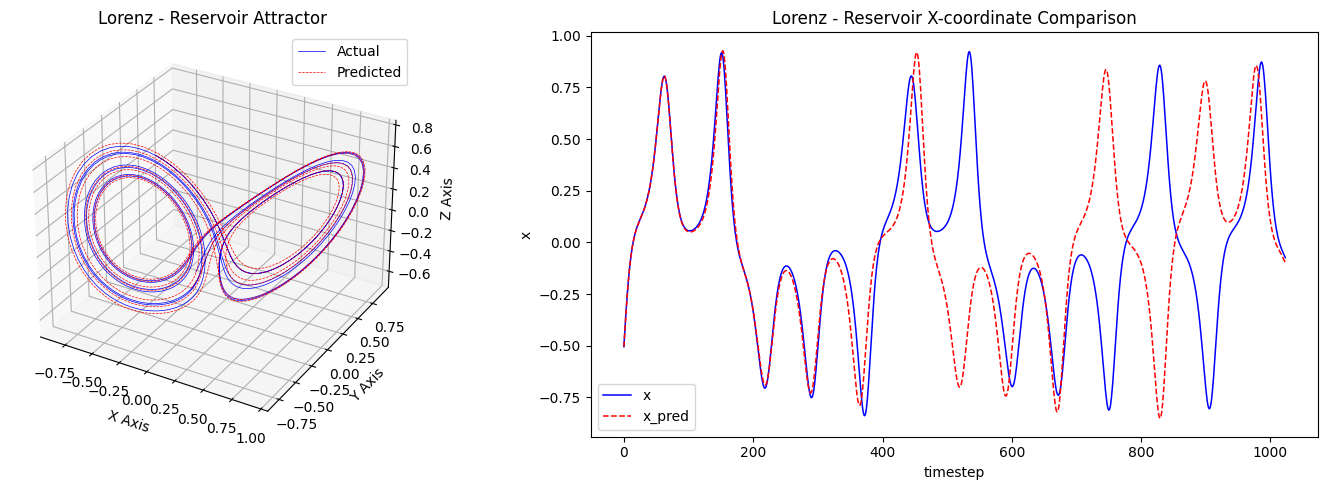

Processing FlowMixer...


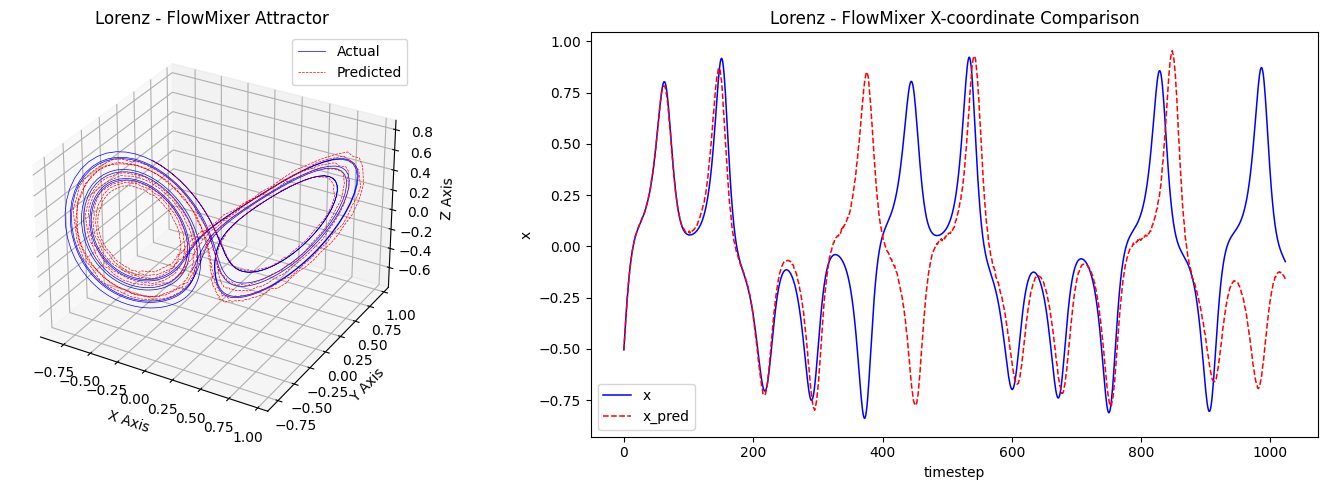

Processing LSTM...


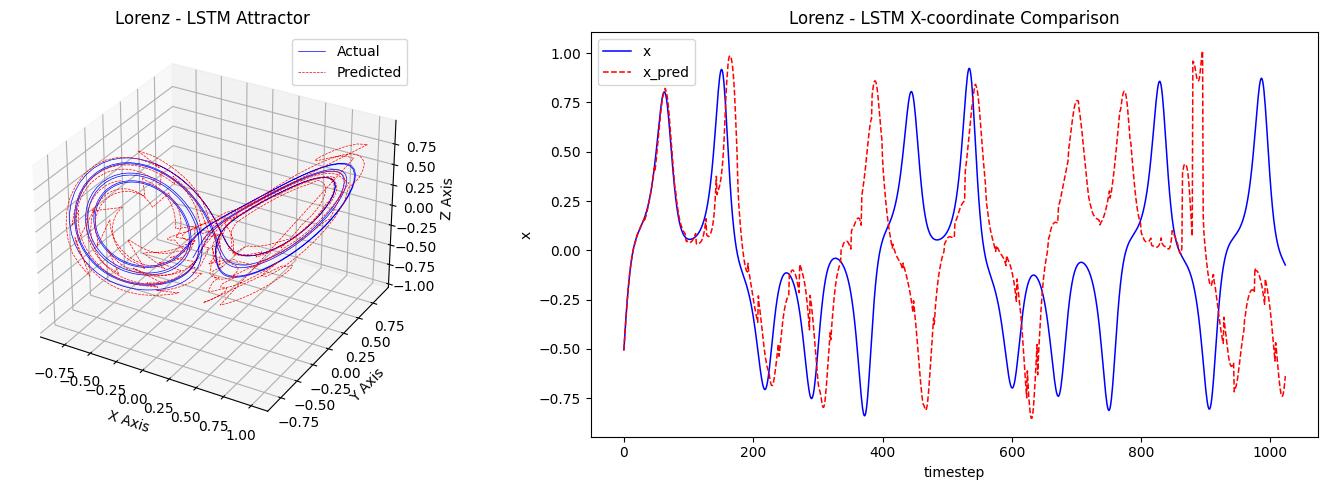

Processing NBEATS...


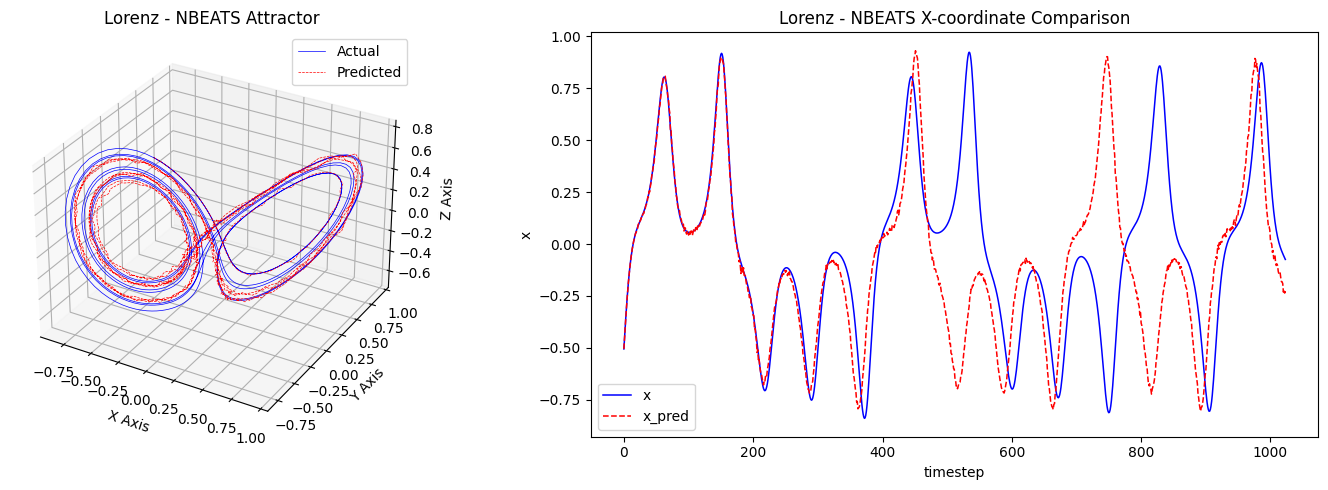


Generating predictions for Rossler dataset:
Processing Reservoir...


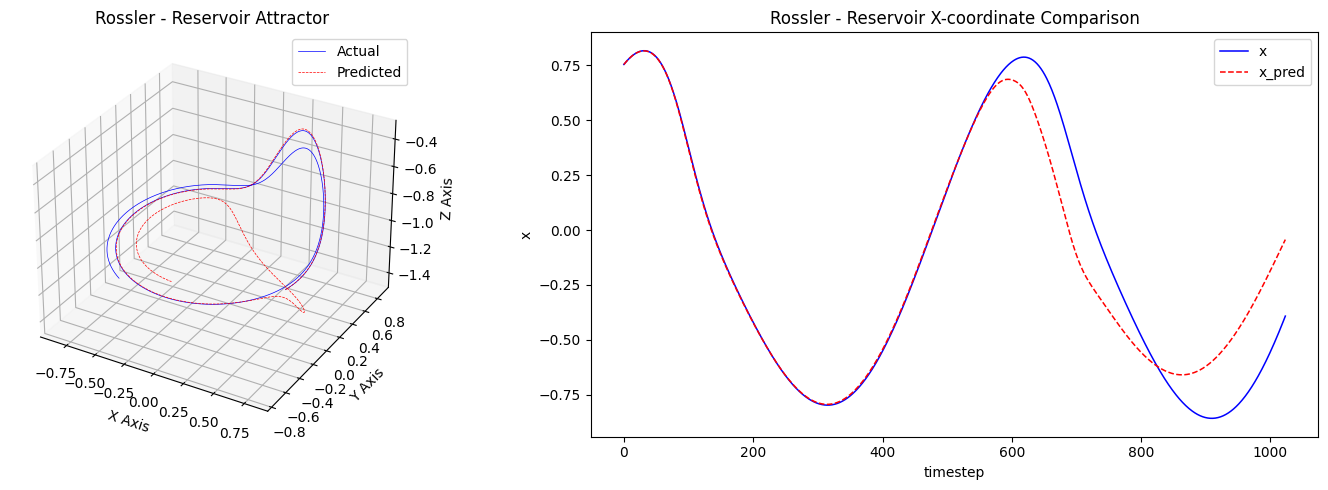

Processing FlowMixer...


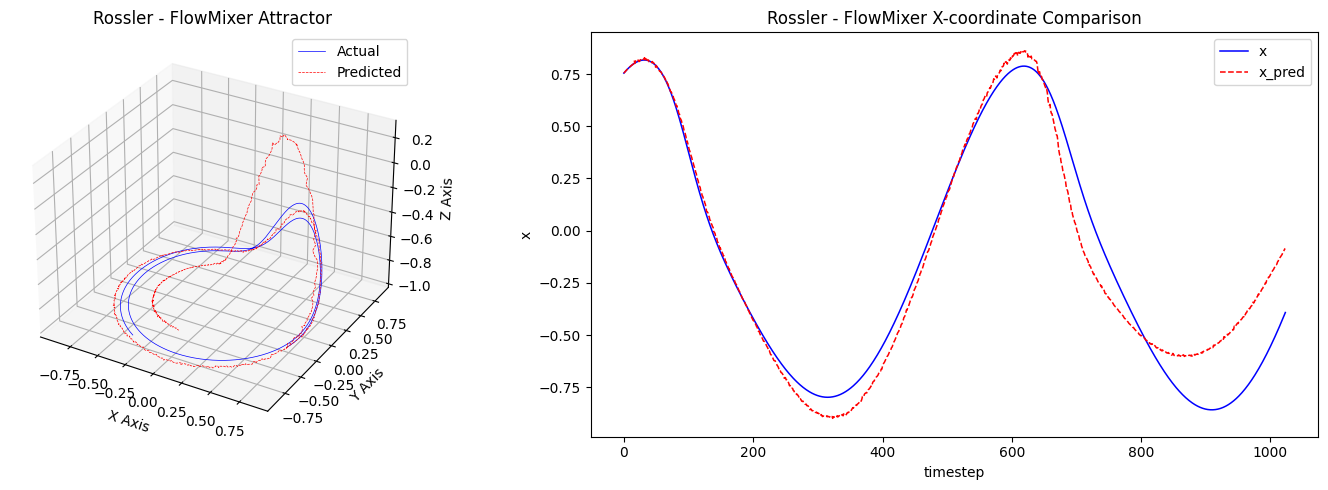

Processing LSTM...


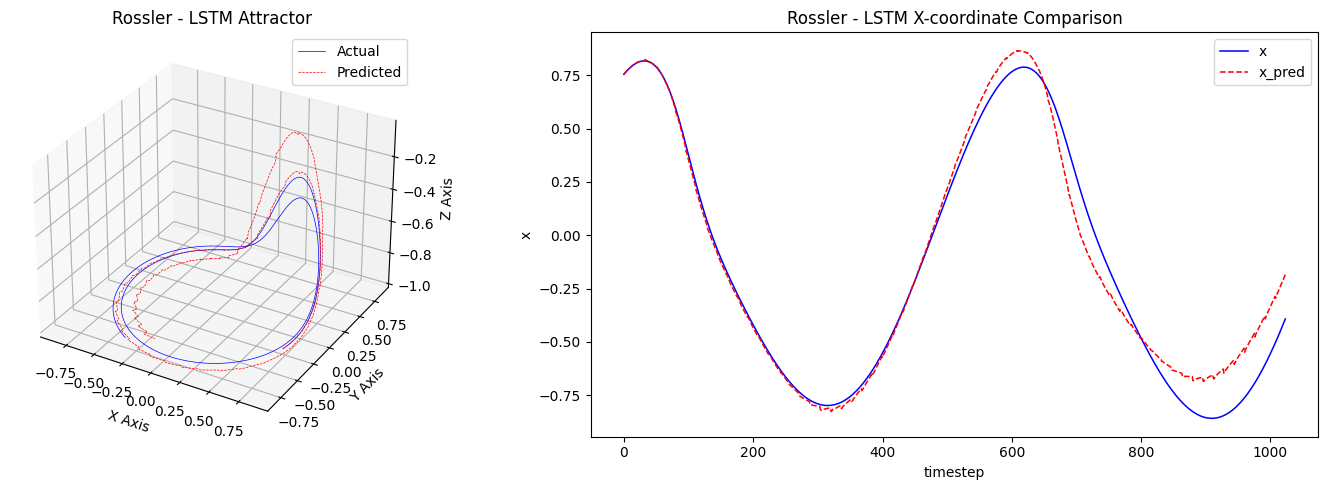

Processing NBEATS...


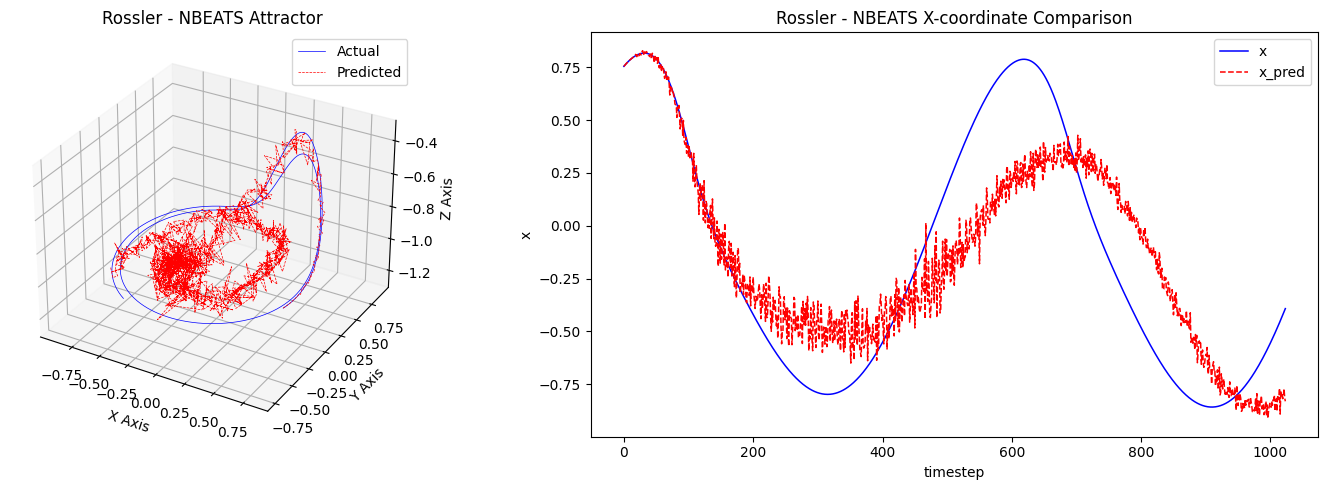


Generating predictions for Aizawa dataset:
Processing Reservoir...


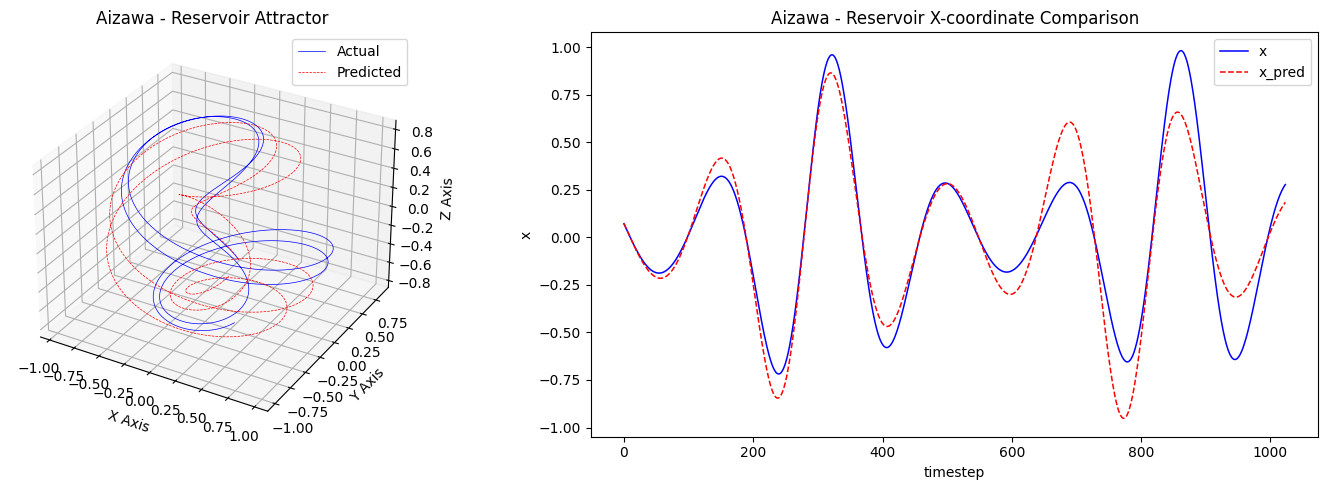

Processing FlowMixer...


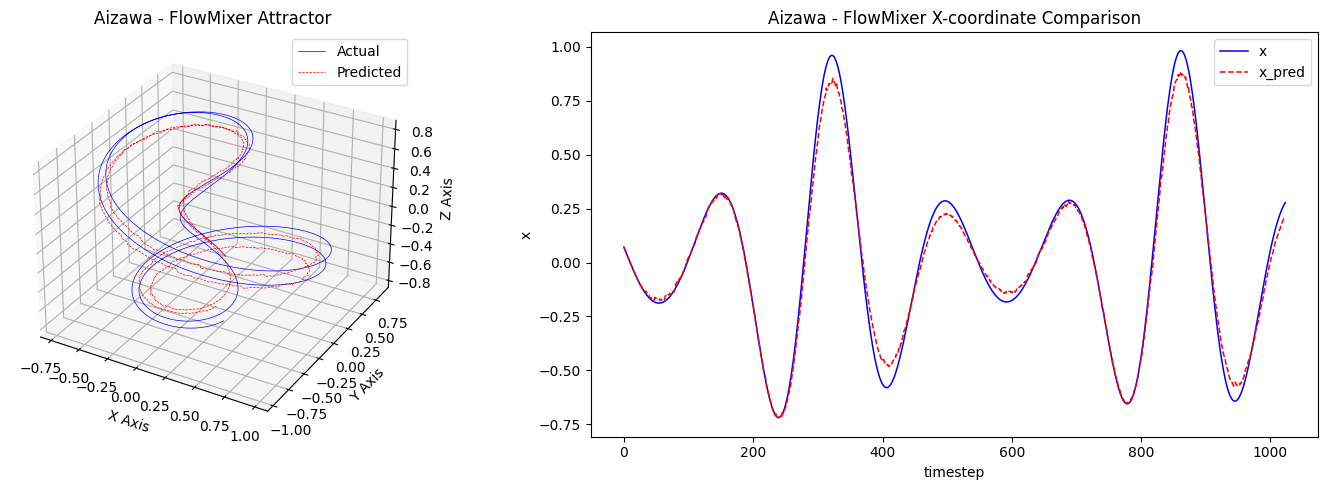

Processing LSTM...


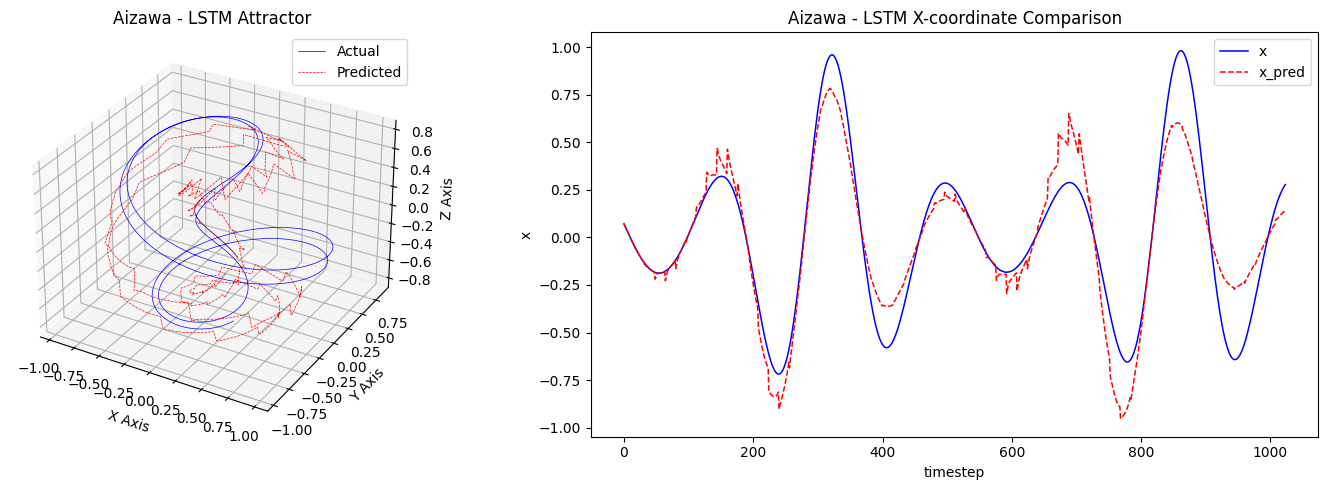

Processing NBEATS...


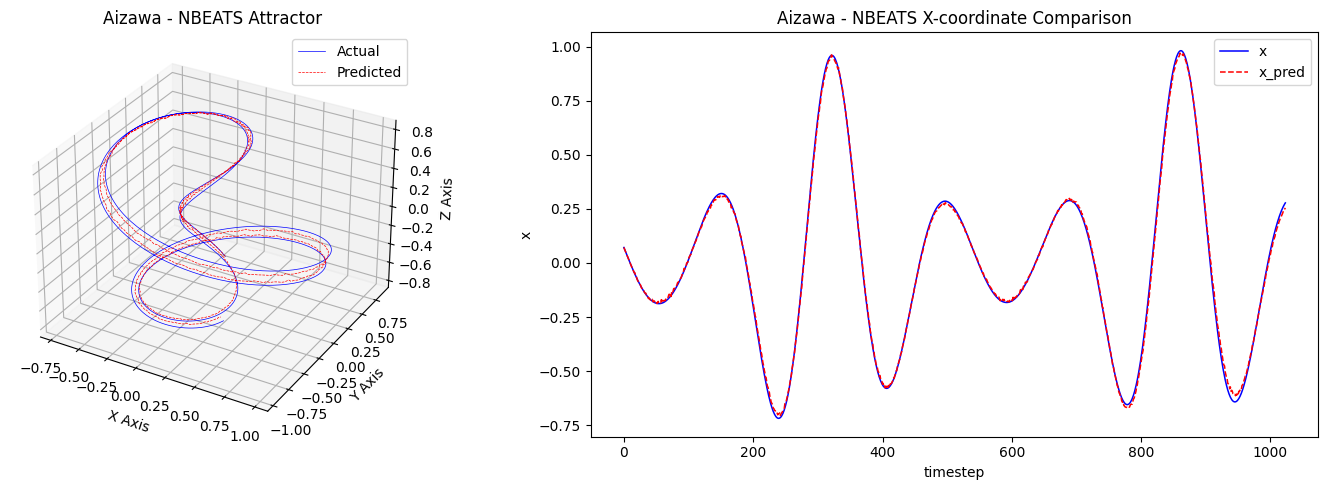

In [ ]:
# All results
prediction_results = generate_all_predictions(all_results, horizon=1024)

<ipython-input-71-c669db85a93a>:96: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


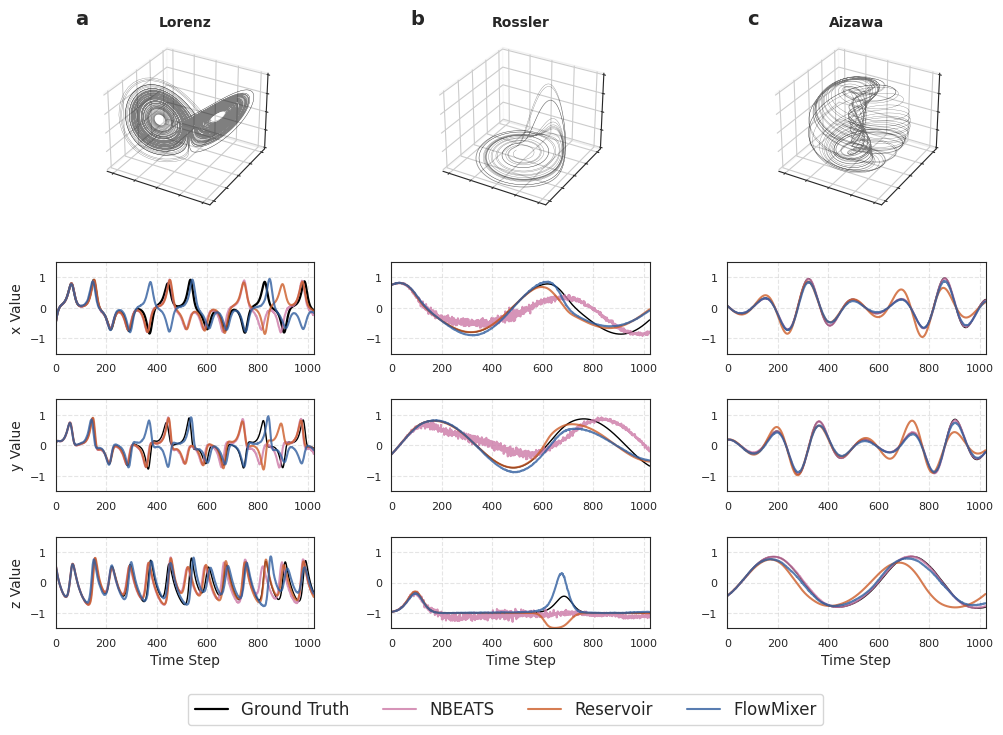

In [ ]:
# @title Plot Figure 3
# Plot


import seaborn as sns

def plot_overlaid_comparison(prediction_results, datasets, model_types, raw_data):
    sns.set_style("white")
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8

    fig = plt.figure(figsize=(12, 7))

    # Nature theme
    color_dict = {
      'Ground Truth': '#000000',
      'FlowMixer': '#2F5D9E',    # Deep blue
      'LSTM': '#009E73',         # Forest green  006837
      'NBEATS': '#CC79A7',       # Wine red CC79A7 009E73
      'Reservoir': '#CC5C28'     # Royal purple
    }

    coord_labels = ['x', 'y', 'z']
    gs = fig.add_gridspec(4, 3, height_ratios=[2, 1, 1, 1])
    leg_lines = []
    leg_labels = []

    for col, dataset in enumerate(datasets):
        full_data = raw_data[dataset][0, :, :3]
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_data = scaler.fit_transform(full_data)

        ax = fig.add_subplot(gs[0, col], projection='3d')
        ax.plot(scaled_data[:, 0], scaled_data[:, 1], scaled_data[:, 2],
                color='black', alpha=0.5, linewidth=0.25)
        ax.set_title(f'{dataset}', fontweight='bold', pad=5)

        ax.grid(True, linestyle='--', alpha=0.1)
        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_xticks([-1,-0.5, 0, 0.5, 1])
        ax.set_yticks([-1,-0.5, 0, 0.5, 1])
        ax.set_zticks([-1,-0.5, 0, 0.5, 1])

        ax.text2D(-0.1, 1.05, chr(97 + col), transform=ax.transAxes,
                 fontsize=14, fontweight='bold')

        for row in range(1, 4):
            ax = fig.add_subplot(gs[row, col])
            coord_idx = row - 1

            # Plot ground truth once
            ground_truth = prediction_results[dataset][model_types[0]]['ground_truth']
            if col == 0 and row == 1:
                line = ax.plot(ground_truth[:, coord_idx],
                           color='black', label='Ground Truth', linewidth=1.6)
                leg_lines.extend(line)
                leg_labels.append('Ground Truth')
            else:
                ax.plot(ground_truth[:, coord_idx],
                       color='black', linewidth=1)

            # Plot predictions
            for model_type in model_types:
                predictions = prediction_results[dataset][model_type]['predictions']

                if col == 0 and row == 1:
                    line = ax.plot(predictions[:, coord_idx],
                           color=color_dict[model_type], label=model_type, linewidth=1.5, alpha=0.8)
                    leg_lines.extend(line)
                    leg_labels.append(model_type)
                else:
                    ax.plot(predictions[:, coord_idx],
                           color=color_dict[model_type], linewidth=1.5, alpha=0.8)

            ax.grid(True, linestyle='--', alpha=0.5)
            if col == 0:
                ax.set_ylabel(f'{coord_labels[coord_idx]} Value')
            if row == 3:
                ax.set_xlabel('Time Step')
            ax.set_ylim(-1.5, 1.5)
            ax.set_xlim(0, 1024)

            for spine in ax.spines.values():
                spine.set_visible(True)

    fig.legend(leg_lines, leg_labels,
              loc='lower center', ncol=len(model_types) + 1,
              bbox_to_anchor=(0.5, -0.05), fontsize=12,
              frameon=True, fancybox=True, shadow=False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, bottom=0.1, hspace=0.4, wspace=0.3)
    plt.savefig('overlaid_comparison.pdf', dpi=300)
    plt.savefig('/content/drive/MyDrive/FlowMixer/figures/overlaid_comparison.pdf', dpi=300)
    plt.show()

# Run code
datasets = ['Lorenz', 'Rossler', 'Aizawa']
model_types = ['NBEATS','Reservoir', 'FlowMixer']
raw_data = {
    'Lorenz': data_lorenz,
    'Rossler': data_rossler,
    'Aizawa': data_aizawa
}
plot_overlaid_comparison(prediction_results, datasets, model_types, raw_data)

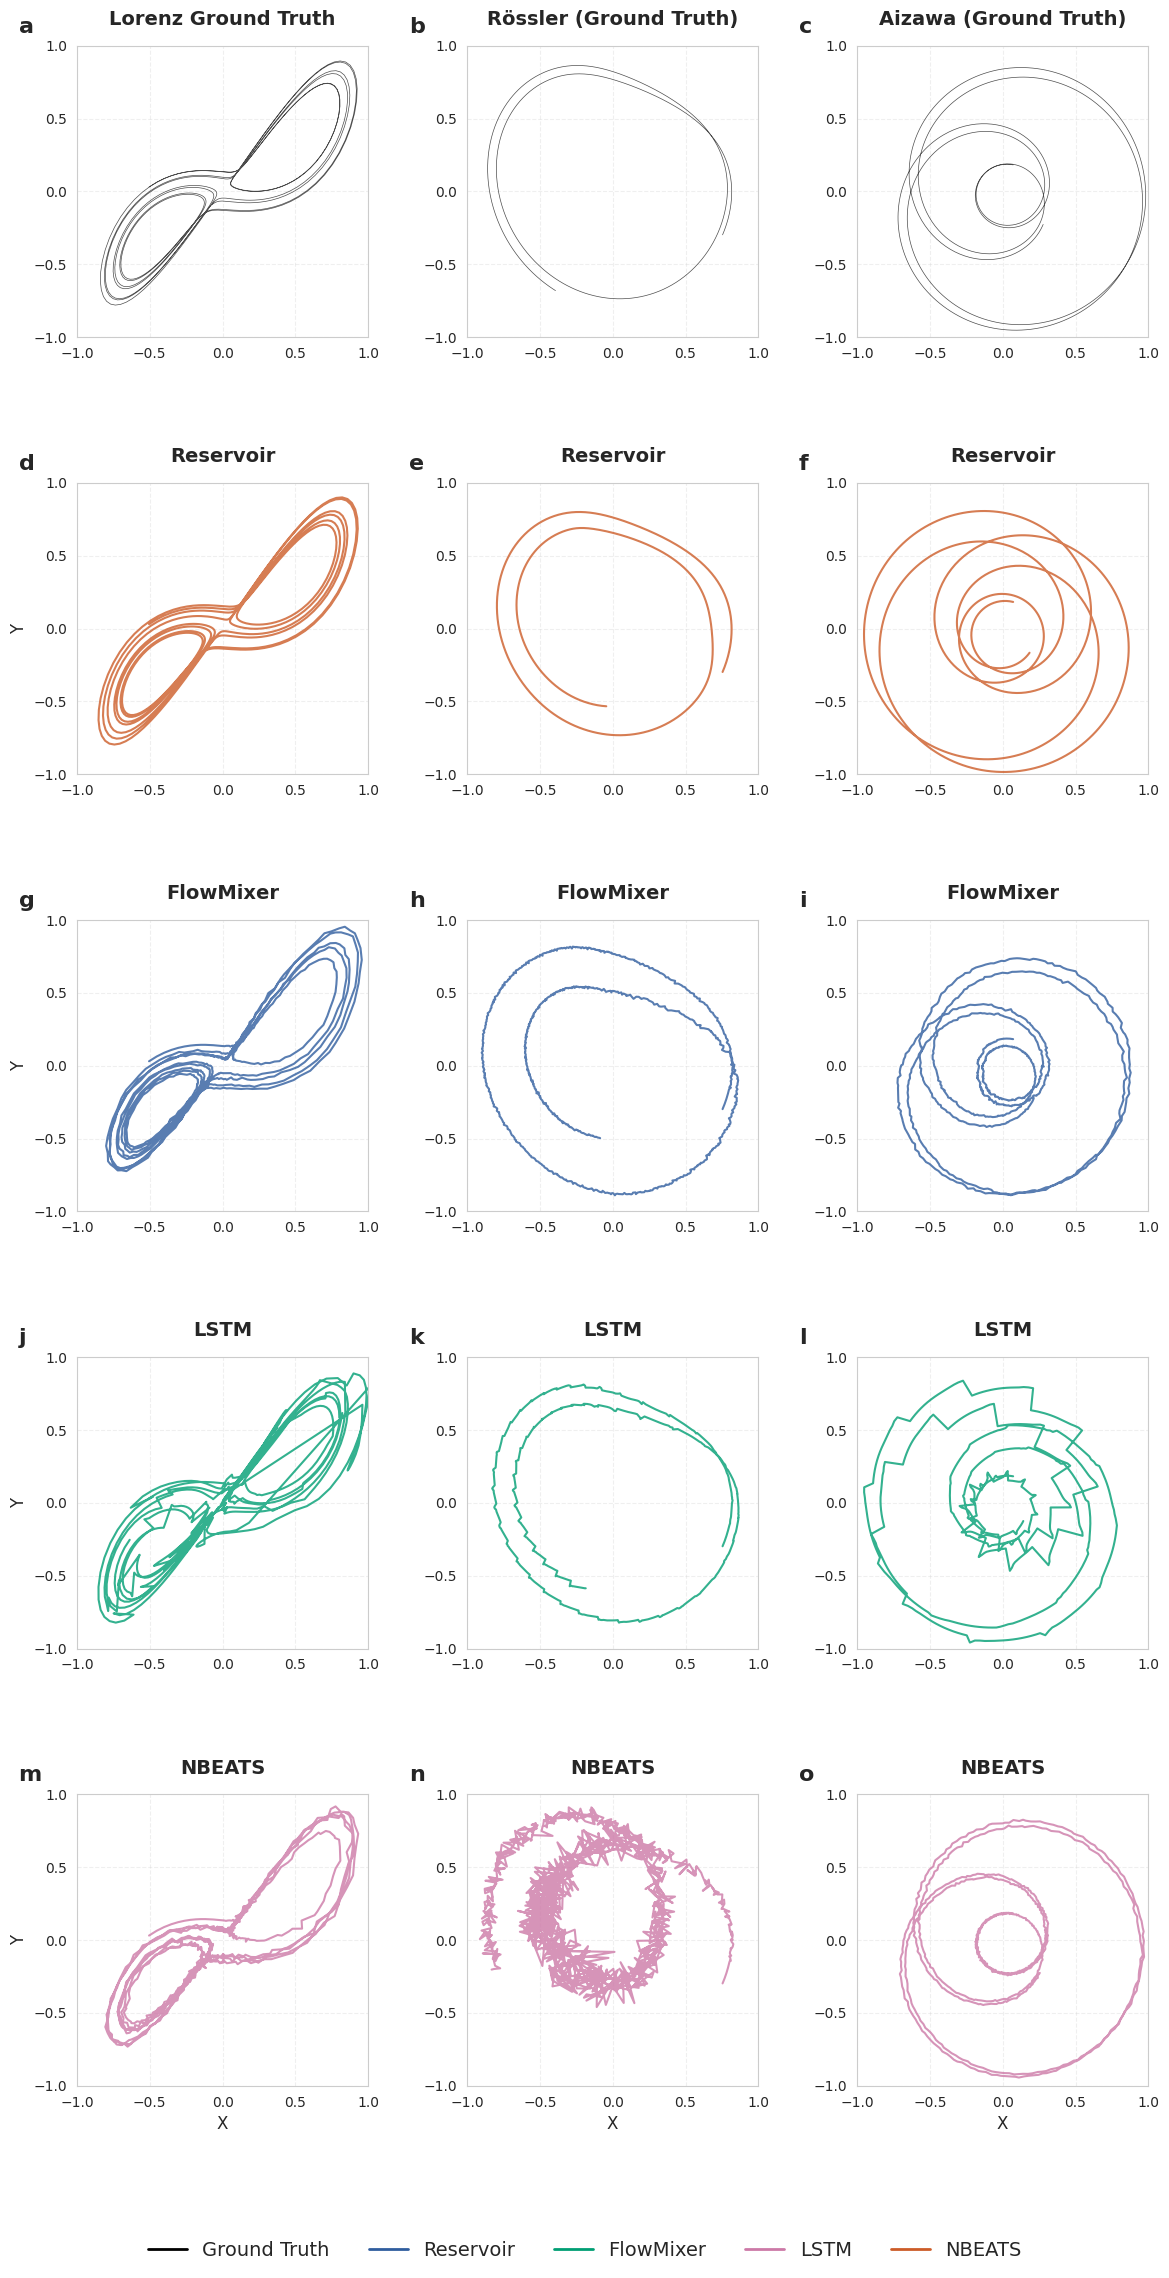

In [ ]:
# @title Plot X-Y
# Plot XY


def plot_xy_comparison(prediction_results, datasets, model_types, raw_data):

    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--'
    })


    color_dict = {
      'Ground Truth': '#000000',
      'FlowMixer': '#2F5D9E',    # Deep blue
      'LSTM': '#009E73',         #
      'NBEATS': '#CC79A7',       #
      'Reservoir': '#CC5C28'     #
    }


    fig = plt.figure(figsize=(12, 24))
    gs = fig.add_gridspec(5, 3, height_ratios=[1, 1, 1, 1, 1])

    titles = {
        'Lorenz': 'Lorenz Ground Truth',
        'Rossler': 'Rössler (Ground Truth)',
        'Aizawa': 'Aizawa (Ground Truth)'
    }

    for col, dataset in enumerate(datasets):
        # Ground truth plots
        ground_truth = prediction_results[dataset][model_types[0]]['ground_truth']
        ax = fig.add_subplot(gs[0, col])
        ax.plot(ground_truth[:, 0], ground_truth[:, 1],
                color=color_dict['Ground Truth'], alpha=0.7, linewidth=0.5)

        # Title for ground truth
        ax.set_title(titles[dataset], fontweight='bold', pad=15, fontsize=14)

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xticks([-1, -0.5, 0, 0.5, 1])
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.grid(True, linestyle='--', alpha=0.3)

        # Label for ground truth
        ax.text(-0.2, 1.1, chr(97 + col), transform=ax.transAxes,
               fontsize=16, fontweight='bold', va='top', ha='left')

        # Model predictions
        for row, model_type in enumerate(model_types, start=1):
            ax = fig.add_subplot(gs[row, col])
            predictions = prediction_results[dataset][model_type]['predictions']
            ax.plot(predictions[:, 0], predictions[:, 1],
                   color=color_dict[model_type], alpha=0.8, linewidth=1.5)

            # Add model type label for all subplots
            ax.set_title(model_type, fontweight='bold', pad=15, fontsize=14)

            ax.grid(True, linestyle='--', alpha=0.3)
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            ax.set_xticks([-1, -0.5, 0, 0.5, 1])
            ax.set_yticks([-1, -0.5, 0, 0.5, 1])
            ax.set_aspect('equal', adjustable='box')

            if col == 0:
                ax.set_ylabel('Y', fontsize=12)
            if row == len(model_types):
                ax.set_xlabel('X', fontsize=12)

            # Sequential labeling
            label_idx = 3 * row + col
            ax.text(-0.2, 1.1, chr(97 + label_idx), transform=ax.transAxes,
                   fontsize=16, fontweight='bold', va='top', ha='left')

    # Legend
    lines = [plt.Line2D([0], [0], color=color, lw=2)
             for method, color in color_dict.items()
             if method == 'Ground Truth' or method in model_types]
    labels = ['Ground Truth'] + model_types
    fig.legend(lines, labels, loc='lower center',
              ncol=len(model_types) + 1, bbox_to_anchor=(0.5, 0.02),
              fontsize=14, frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, bottom=0.1, hspace=0.5, wspace=0.3)
    plt.savefig('xy_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.savefig('/content/drive/MyDrive/FlowMixer/figures/xy_comparison.pdf', dpi=300)
    plt.show()

# Run code
datasets = ['Lorenz', 'Rossler', 'Aizawa']
model_types = ['Reservoir', 'FlowMixer', 'LSTM', 'NBEATS']
raw_data = {
    'Lorenz': data_lorenz,
    'Rossler': data_rossler,
    'Aizawa': data_aizawa
}
plot_xy_comparison(prediction_results, datasets, model_types, raw_data)

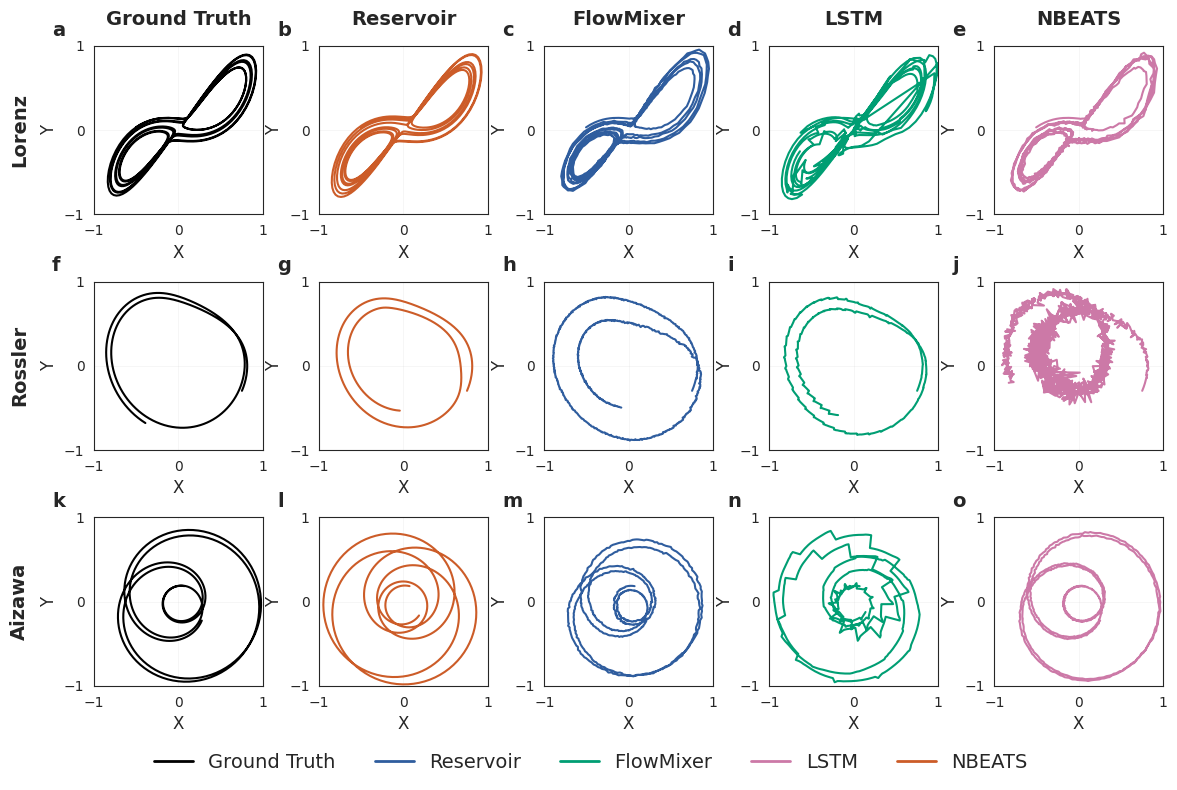

In [ ]:
def plot_xy_comparison(prediction_results, datasets, model_types, raw_data):
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 12,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'axes.grid': True,
        'grid.alpha': 0.3,
        'grid.linestyle': '--'
    })

    color_dict = {
      'Ground Truth': '#000000',
      'FlowMixer': '#2F5D9E',
      'LSTM': '#009E73',
      'NBEATS': '#CC79A7',
      'Reservoir': '#CC5C28'
    }

    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 1, 1, 1])

    for row, dataset in enumerate(datasets):
        # First add dataset label to first column
        ax = fig.add_subplot(gs[row, 0])
        ax.text(-0.5, 0.5, dataset, rotation=90, transform=ax.transAxes,
                fontsize=14, fontweight='bold', va='center')

        # Ground truth plot
        ground_truth = prediction_results[dataset][model_types[0]]['ground_truth']
        ax.plot(ground_truth[:, 0], ground_truth[:, 1],
                color=color_dict['Ground Truth'], alpha=1.0, linewidth=1.5)

        if row == 0:
            ax.set_title('Ground Truth', fontweight='bold', pad=15, fontsize=14)

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xticks([-1, 0, 1])
        ax.set_yticks([-1, 0, 1])
        ax.grid(True, linestyle='-', alpha=0.25, linewidth=0.5)
        ax.set_xlabel('X', fontsize=12)
        ax.set_ylabel('Y', fontsize=12)

        # Sequential labeling
        ax.text(-0.25, 1.15, chr(97 + row * 5), transform=ax.transAxes,
               fontsize=14, fontweight='bold', va='top', ha='left')

        # Model predictions
        for col, model_type in enumerate(model_types, start=1):
            ax = fig.add_subplot(gs[row, col])
            predictions = prediction_results[dataset][model_type]['predictions']
            ax.plot(predictions[:, 0], predictions[:, 1],
                   color=color_dict[model_type], alpha=1.0, linewidth=1.5)

            if row == 0:
                ax.set_title(model_type, fontweight='bold', pad=15, fontsize=14)

            ax.grid(True, linestyle='-', alpha=0.25, linewidth=0.5)
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
            ax.set_xticks([-1, 0, 1])
            ax.set_yticks([-1, 0, 1])
            ax.set_aspect('equal', adjustable='box')
            ax.set_xlabel('X', fontsize=12)
            ax.set_ylabel('Y', fontsize=12)

            label_idx = row * 5 + col
            ax.text(-0.25, 1.15, chr(97 + label_idx), transform=ax.transAxes,
                   fontsize=14, fontweight='bold', va='top', ha='left')

    lines = [plt.Line2D([0], [0], color=color, lw=2)
             for method, color in color_dict.items()
             if method == 'Ground Truth' or method in model_types]
    labels = ['Ground Truth'] + model_types
    fig.legend(lines, labels, loc='lower center',
              ncol=len(model_types) + 1, bbox_to_anchor=(0.5, 0.02),
              fontsize=14, frameon=False)

    plt.tight_layout()
    plt.subplots_adjust(top=0.95, bottom=0.15, hspace=0.4, wspace=0.3)
    plt.savefig('xy_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.show()

datasets = ['Lorenz', 'Rossler', 'Aizawa']
model_types = ['Reservoir', 'FlowMixer', 'LSTM', 'NBEATS']
raw_data = {
    'Lorenz': data_lorenz,
    'Rossler': data_rossler,
    'Aizawa': data_aizawa
}
plot_xy_comparison(prediction_results, datasets, model_types, raw_data)

Testing Reservoir with original parameters...
MSE: 33.912715
MAE: 2.931507


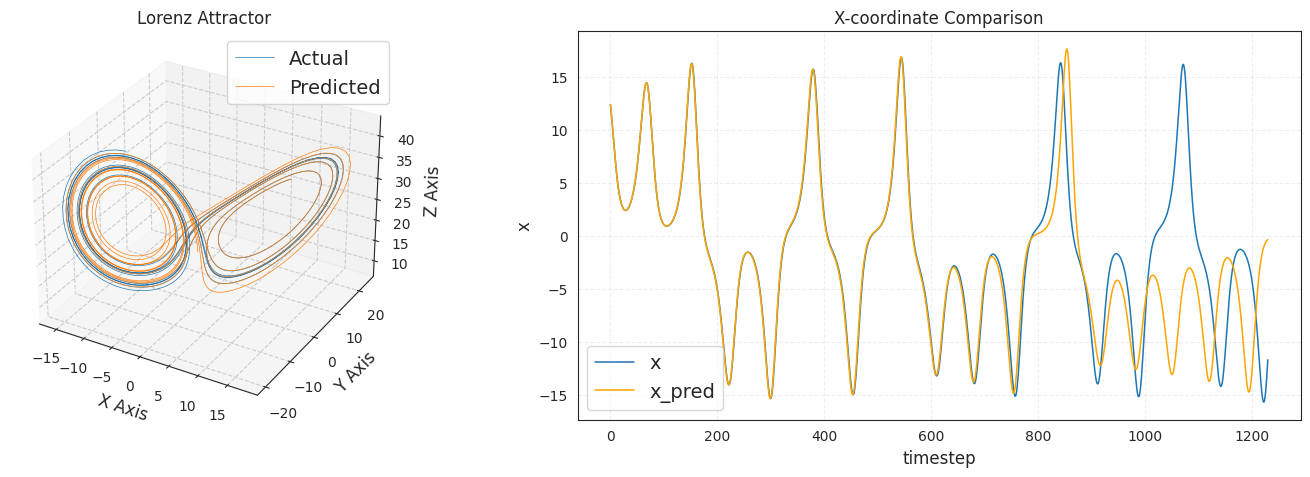

In [ ]:
# @title Standalone RC (Unscaled)

tf.random.set_seed(888)
np.random.seed(888)

def test_reservoir(data_lorenz):
    """Test Reservoir performance on Lorenz data"""
    print("Testing Reservoir with original parameters...")

    # Prepare data exactly as original
    data = data_lorenz[0, :, :3]  # First trajectory, only x,y,z
    params = get_model_params('Reservoir')
    # Split data
    data_length = len(data)
    training_percentage = 0.9
    training_data = data[:int(data_length * training_percentage)]
    valid_data = data[int(data_length * training_percentage):]


    #training_data,valid_data,scaler=prepare_data(data_lorenz, params)
    #training_data = training_data[:,:,:3].squeeze()
    #valid_data = valid_data[:,:,:3].squeeze()


    # Create and train model
    model = ReservoirComputer(
        dim_system=3,
        dim_reservoir=300,
        rho=1.1,
        sigma=0.2,
        density=0.05
    )

    # Train
    model.train(training_data)

    # Predict
    predicted_data = model.predict(len(valid_data))

    # Calculate metrics
    mse = np.mean((valid_data - predicted_data) ** 2)
    mae = np.mean(np.abs(valid_data - predicted_data))

    print(f"MSE: {mse:.6f}")
    print(f"MAE: {mae:.6f}")

    # Plot for verification
    fig = plt.figure(figsize=(15, 5))

    # 3D trajectory plot
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(valid_data[:, 0], valid_data[:, 1], valid_data[:, 2],
             lw=0.5, label="Actual")
    ax1.plot(predicted_data[:, 0], predicted_data[:, 1], predicted_data[:, 2],
             lw=0.5, label="Predicted")
    ax1.set_xlabel("X Axis")
    ax1.set_ylabel("Y Axis")
    ax1.set_zlabel("Z Axis")
    ax1.legend()
    ax1.set_title("Lorenz Attractor")

    # Time series plot
    ax2 = fig.add_subplot(122)
    timesteps = range(len(valid_data))
    ax2.plot(timesteps[:2000], valid_data[:2000, 0], label="x", lw=1.1)
    ax2.plot(timesteps[:2000], predicted_data[:2000, 0], label="x_pred", lw=1.1, color='orange')
    ax2.set_ylabel("x")
    ax2.set_xlabel("timestep")
    ax2.set_title("X-coordinate Comparison")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return model, predicted_data, valid_data

# Run test
if __name__ == "__main__":
    model, predictions, actual = test_reservoir(data_lorenz)